# Linear Binary Pattern

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [6]:
from skimage import io
from skimage.feature import local_binary_pattern

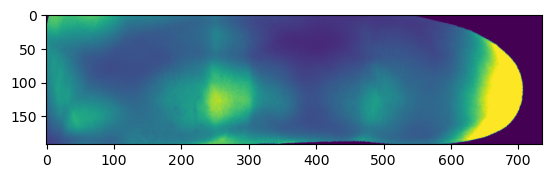

In [7]:
fingerprint = io.imread('../data/Data_FV_Spoofing_WS2025_26/PLUS/real/001/PLUS-FV3-Laser_PALMAR_001_01_02_01.png')
plt.imshow(fingerprint)
plt.show()

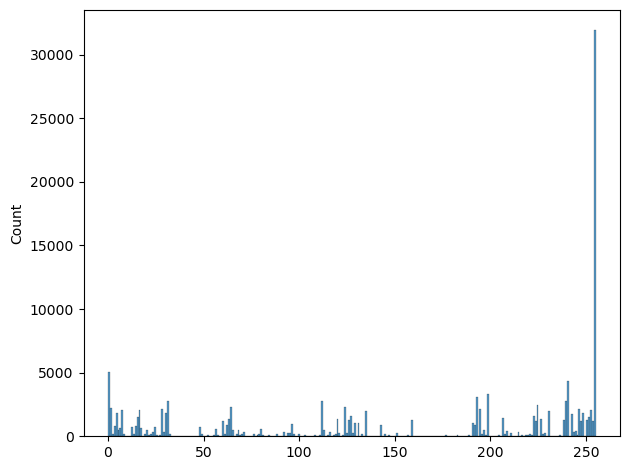

In [8]:
lbp = local_binary_pattern(fingerprint, P=8, R=1)
sns.histplot(lbp.ravel(), bins=256)
hist = np.bincount(lbp.ravel().astype(np.uint8))
plt.tight_layout()
plt.show()

## Preparing fingerprint data

In [9]:
import re
from pathlib import Path

def fingerprint_metadata(base_path, pattern):
    base_path = Path(base_path)
    return pd.DataFrame([(*pattern.findall(f.name)[0], f) for f in base_path.rglob('*.png')])

In [10]:
plus_pattern = re.compile(r"(.+)_(PALMAR|DORSAL)_([0-9]+)_([0-9]+)_([0-9]+)_([0-9]+).png")
idiap_pattern = re.compile(r"([0-9]+)_(L|R)_([0-9]+).png")
scut_pattern = re.compile(r"([0-9]+)_([0-9]+)_([0-9]+)_([0-9]+)_([0-9]+).bmp")
plus_map = {k:v for k,v in enumerate(['laser', 'side', 'subject', 'session', 'finger', 'image_id', 'path'])}
idiap_map = {k:v for k,v in enumerate(['subject', 'side', 'session', 'path'])}
scut_map = {k:v for k,v in enumerate(['subject', 'finger', 'session', 'shot', 'light', 'path'])}

# CHANGE PATH TO GET OTHER DATASETS
real = fingerprint_metadata('../data/Data_FV_Spoofing_WS2025_26/IDIAP/cropped/dev/real/', idiap_pattern).rename(columns=idiap_map)
real['label'] = 'real'
spoof = fingerprint_metadata('../data/Data_FV_Spoofing_WS2025_26/IDIAP/cropped/dev/spoof/', idiap_pattern).rename(columns=idiap_map)
spoof['label'] = 'spoof'
real.head()

,subject,side,session,path,label
0,032,L,1,../data/Data_FV_Spoofing_WS2025_26/IDIAP/cropp...,real
1,032,L,2,../data/Data_FV_Spoofing_WS2025_26/IDIAP/cropp...,real
2,032,R,1,../data/Data_FV_Spoofing_WS2025_26/IDIAP/cropp...,real
3,032,R,2,../data/Data_FV_Spoofing_WS2025_26/IDIAP/cropp...,real
4,033,L,1,../data/Data_FV_Spoofing_WS2025_26/IDIAP/cropp...,real


In [11]:
# CREATE THE BALANCED DATASET
KEYS = ["subject", "side"]

# Identify shared (user_id, finger_id) pairs
common_keys = (
    real[KEYS]
    .merge(spoof[KEYS], on=KEYS, how="inner")
    .drop_duplicates()
)

# Filter both tables to the shared pairs
df_pos_balanced = real.merge(common_keys, on=KEYS, how="inner")
df_neg_balanced = spoof.merge(common_keys, on=KEYS, how="inner")

# Stack rows while preserving schema and labels
balanced_df = pd.concat(
    [df_pos_balanced, df_neg_balanced],
    ignore_index=True
)

balanced_df

,subject,side,session,path,label
0,032,L,1,../data/Data_FV_Spoofing_WS2025_26/IDIAP/cropp...,real
1,032,L,2,../data/Data_FV_Spoofing_WS2025_26/IDIAP/cropp...,real
2,032,R,1,../data/Data_FV_Spoofing_WS2025_26/IDIAP/cropp...,real
3,032,R,2,../data/Data_FV_Spoofing_WS2025_26/IDIAP/cropp...,real
4,033,L,1,../data/Data_FV_Spoofing_WS2025_26/IDIAP/cropp...,real
...,...,...,...,...,...
235,071,R,2,../data/Data_FV_Spoofing_WS2025_26/IDIAP/cropp...,spoof
236,072,L,1,../data/Data_FV_Spoofing_WS2025_26/IDIAP/cropp...,spoof
237,072,L,2,../data/Data_FV_Spoofing_WS2025_26/IDIAP/cropp...,spoof
238,072,R,1,../data/Data_FV_Spoofing_WS2025_26/IDIAP/cropp...,spoof


In [12]:
# Takes fingerprint image path and converts it to a normalized histogram of the lbp results
def extract_feature(path: str) -> np.ndarray:
    fingerprint = io.imread(path)
    lbp = local_binary_pattern(fingerprint, P=8, R=1, method="default")
    lbp = lbp.astype(np.uint8)
    hist, _ = np.histogram(
        lbp.ravel(),
        bins=256,
        range=(0, 256)
    )
    hist = hist.astype(np.float32)
    hist /= hist.sum() + 1e-8
    return hist

In [13]:
# Add the feature column to the dataset
balanced_df['feature'] = balanced_df['path'].apply(extract_feature)

#Convert subject (user_id) to numeric
balanced_df["subject"] = pd.to_numeric(balanced_df["subject"], errors="coerce")
balanced_df

,subject,side,session,path,label,feature
0,32,L,1,../data/Data_FV_Spoofing_WS2025_26/IDIAP/cropp...,real,"[0.12250148, 0.019351032, 0.004884956, 0.00736..."
1,32,L,2,../data/Data_FV_Spoofing_WS2025_26/IDIAP/cropp...,real,"[0.1262537, 0.02361062, 0.0046725664, 0.006902..."
2,32,R,1,../data/Data_FV_Spoofing_WS2025_26/IDIAP/cropp...,real,"[0.11687316, 0.018643068, 0.0041061947, 0.0080..."
3,32,R,2,../data/Data_FV_Spoofing_WS2025_26/IDIAP/cropp...,real,"[0.12021239, 0.018159293, 0.0037404129, 0.0060..."
4,33,L,1,../data/Data_FV_Spoofing_WS2025_26/IDIAP/cropp...,real,"[0.1199764, 0.015327434, 0.0035516224, 0.00547..."
...,...,...,...,...,...,...
235,71,R,2,../data/Data_FV_Spoofing_WS2025_26/IDIAP/cropp...,spoof,"[0.10920354, 0.0124955755, 0.005616519, 0.0066..."
236,72,L,1,../data/Data_FV_Spoofing_WS2025_26/IDIAP/cropp...,spoof,"[0.109368734, 0.011492626, 0.005132743, 0.0067..."
237,72,L,2,../data/Data_FV_Spoofing_WS2025_26/IDIAP/cropp...,spoof,"[0.11165782, 0.011221239, 0.0052507375, 0.0059..."
238,72,R,1,../data/Data_FV_Spoofing_WS2025_26/IDIAP/cropp...,spoof,"[0.10916814, 0.011433628, 0.005038348, 0.00640..."


In [14]:
# Convert relevant columns to a list to input into 'crossvalidation'
data = balanced_df[['feature', 'label', 'subject']].values.tolist()
data[0]

[array([1.22501478e-01, 1.93510316e-02, 4.88495594e-03, 7.36283185e-03,
        2.38230079e-02, 3.05604725e-03, 7.95280281e-03, 5.47492644e-03,
        2.33628321e-03, 1.01474929e-03, 3.89380526e-04, 1.20353978e-03,
        4.47197631e-03, 1.19174039e-03, 3.65781714e-03, 4.90855472e-03,
        1.80884954e-02, 3.28023592e-03, 1.93510321e-03, 2.34808261e-03,
        6.99705025e-03, 5.30973426e-04, 2.69026542e-03, 1.35693210e-03,
        3.69321532e-03, 1.05014746e-03, 8.84955749e-04, 2.26548663e-03,
        7.18584051e-03, 1.03834807e-03, 7.57522136e-03, 9.42772906e-03,
        4.40117996e-03, 2.04129796e-03, 2.71386438e-04, 7.31563428e-04,
        5.30973426e-04, 1.29793509e-04, 2.12389379e-04, 2.47787597e-04,
        4.95575194e-04, 4.01179946e-04, 8.25958705e-05, 3.42182902e-04,
        4.24778758e-04, 1.53392335e-04, 2.00589973e-04, 6.13569340e-04,
        7.91740417e-03, 1.79351028e-03, 5.42772876e-04, 1.10914453e-03,
        1.55752210e-03, 1.65191741e-04, 6.25368732e-04, 2.713864

In [15]:
#Necaissairy to get rid of multiplicates

data_clean = []
seen = set()

for i in range(len(data)):
        combo = (data[i][1], data[i][2])  # hashable tuple
        if combo not in seen:
            data_clean.append(data[i])
            seen.add(combo)

print(len(data_clean))
for i in range(len(data_clean)):
    print(data_clean[i][2])

60
32
33
34
35
36
37
38
39
40
42
50
51
52
53
54
55
56
57
58
59
60
62
63
65
66
67
69
70
71
72
32
33
34
35
36
37
38
39
40
42
50
51
52
53
54
55
56
57
58
59
60
62
63
65
66
67
69
70
71
72


# Pipeline

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
import random
from itertools import combinations
from sklearn.metrics import confusion_matrix


def compute_error_rates(true_labels, pred_labels):
    """Compute APCER, BPCER, ACER."""
    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)

    # Define mapping
    labels = ["real", "spoof"]  # Ensure consistent order

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, pred_labels, labels=labels)
    #print(cm)
    TN, FP, FN, TP = cm.ravel()  # Unpack the matrix

    apcer = FN/(FN+TP)
    bpcer = FP/(FP+TN)
    acer = 0.5 * (apcer + bpcer)
    return acer, apcer, bpcer

def train_on_size(trainsize, choices, data_folds, classifier):
    random.shuffle(choices)
    train = sum((data_folds[j] for j in choices[:trainsize]), [])
    random.shuffle(train)
    train_X = [row[0] for row in train]
    train_y = [row[1] for row in train]

    classifier.fit(train_X, train_y)
    return


def crossvalidation(data, dist='manhattan', k=5):
    """
    data: list of [feature_vector (np.array), label ('real'/'spoof'), user_id]

    dist: distance metric to be used by KNNeighborsClassifier

    k: neighbours for knn-classifier

    Returns:
       ACER, APCER, BPCER for:
        - training on 4/5
        - training on 2/5
        - training on 1/5
    """

    # Extract all unique users and create folds
    users = sorted({row[2] for row in data})
    random.shuffle(users)
    size = len(users) // 5
    user_folds = [users[i:i + size] for i in range(0, (len(users)//5)*5, size)]
    data_folds = [
        [row for row in data if row[2] in user_folds[i]]
        for i in range(5)
    ]

    results = {
        "4_of_5": [],
        "2_of_5": [],
        "1_of_5": []
    }

    for i in range(5):
        test_set = data_folds[i]
        test_X = [row[0] for row in test_set]
        test_y = [row[1] for row in test_set]
        choices = list({0, 1, 2, 3, 4} - {i})
        
        # train on 4
        knn = KNeighborsClassifier(n_neighbors=k, metric=dist)
        train_on_size(4, choices, data_folds, knn)
        predictions = knn.predict(test_X)
        acer, apcer, bpcer = compute_error_rates(test_y, predictions)
        results["4_of_5"].append((acer, apcer, bpcer))

        # train on 2
        knn = KNeighborsClassifier(n_neighbors=k,metric=dist)
        train_on_size(2, choices, data_folds, knn)
        predictions = knn.predict(test_X)
        acer, apcer, bpcer = compute_error_rates(test_y, predictions)
        results["2_of_5"].append((acer, apcer, bpcer))

        # train on 1
        knn = KNeighborsClassifier(n_neighbors=k,metric=dist)
        train_on_size(1, choices, data_folds, knn)
        predictions = knn.predict(test_X)
        acer, apcer, bpcer = compute_error_rates(test_y, predictions)
        results["1_of_5"].append((acer, apcer, bpcer))

        
        
    final = {}
    for regime in results:
        arr = np.array(results[regime])
        final[regime] = {
            "ACER":  float(arr[:, 0].mean()),
            "APCER": float(arr[:, 1].mean()),
            "BPCER": float(arr[:, 2].mean())
        }

    return final

In [17]:
# call crossvalidate with the prepared dataset
crossvalidation(data)

{'4_of_5': {'ACER': 0.0375,
  'APCER': 0.041666666666666664,
  'BPCER': 0.03333333333333333},
 '2_of_5': {'ACER': 0.03333333333333333,
  'APCER': 0.03333333333333333,
  'BPCER': 0.03333333333333333},
 '1_of_5': {'ACER': 0.04166666666666667,
  'APCER': 0.058333333333333334,
  'BPCER': 0.025}}

In [213]:
crossvalidation(data_clean)

{'4_of_5': {'ACER': 0.09999999999999999, 'APCER': 0.1, 'BPCER': 0.1},
 '2_of_5': {'ACER': 0.09999999999999999, 'APCER': 0.1, 'BPCER': 0.1},
 '1_of_5': {'ACER': 0.13333333333333333,
  'APCER': 0.13333333333333333,
  'BPCER': 0.13333333333333333}}

In [216]:
import numpy as np
from scipy.stats import entropy
from scipy.stats import wasserstein_distance
from sklearn.neighbors import KNeighborsClassifier

# -----------------------------
# Distance functions (callables)
# -----------------------------

def l1(x, y):
    return np.sum(np.abs(x - y))

def l2(x, y):
    return np.sqrt(np.sum((x - y)**2))

def cos(x, y):
    # KNN expects a distance, so 1 - cosine similarity
    return 1 - (np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y) + 1e-10))

def corr(x, y):
    # 1 - correlation coefficient
    if np.std(x) == 0 or np.std(y) == 0:
        return 1.0
    return 1 - np.corrcoef(x, y)[0, 1]

def chi2(x, y):
    return 0.5 * np.sum((x - y)**2 / (x + y + 1e-10))

def kl(x, y):
    # Ensure probability distributions
    x_norm = x / np.sum(x) if np.sum(x) != 0 else x
    y_norm = y / np.sum(y) if np.sum(y) != 0 else y
    return entropy(x_norm + 1e-10, y_norm + 1e-10)

def emd(x, y):
    # Wasserstein distance
    return wasserstein_distance(x, y)

In [222]:
distances = [l1, l2, cos, corr, chi2, kl, emd]
Ks = [1, 2, 5, 7, 10, 12, 15]

results = {}  # initialize dictionary

for dist in distances:
    results[str(dist)] = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]  # create a list for each distance
    for k in Ks:
        knn = KNeighborsClassifier()
        scores = crossvalidation(data, dist, k)
        results[str(dist)][k] = scores

In [230]:
results

{'<function l1 at 0x00000269BF760AE0>': [0,
  {'4_of_5': {'ACER': 0.06666666666666667,
    'APCER': 0.025,
    'BPCER': 0.10833333333333332},
   '2_of_5': {'ACER': 0.07083333333333333,
    'APCER': 0.016666666666666666,
    'BPCER': 0.125},
   '1_of_5': {'ACER': 0.09166666666666665,
    'APCER': 0.03333333333333333,
    'BPCER': 0.15}},
  {'4_of_5': {'ACER': 0.05, 'APCER': 0.025, 'BPCER': 0.075},
   '2_of_5': {'ACER': 0.041666666666666664,
    'APCER': 0.025,
    'BPCER': 0.05833333333333333},
   '1_of_5': {'ACER': 0.07083333333333333,
    'APCER': 0.049999999999999996,
    'BPCER': 0.09166666666666666}},
  3,
  4,
  {'4_of_5': {'ACER': 0.058333333333333334,
    'APCER': 0.008333333333333333,
    'BPCER': 0.10833333333333332},
   '2_of_5': {'ACER': 0.06666666666666668,
    'APCER': 0.016666666666666666,
    'BPCER': 0.11666666666666665},
   '1_of_5': {'ACER': 0.05416666666666666,
    'APCER': 0.025,
    'BPCER': 0.08333333333333334}},
  6,
  {'4_of_5': {'ACER': 0.05416666666666666,
   

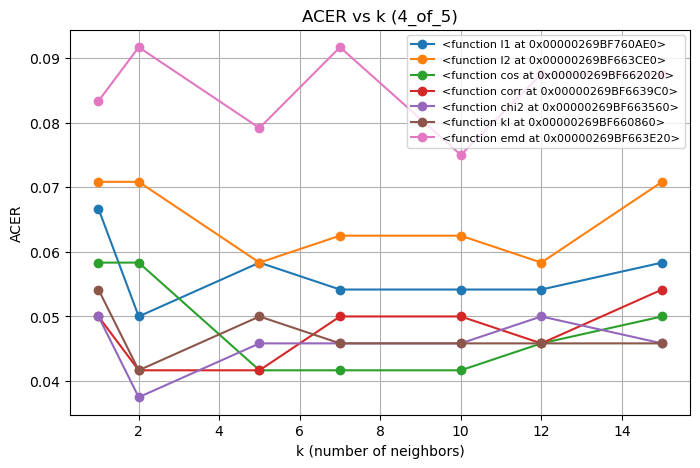

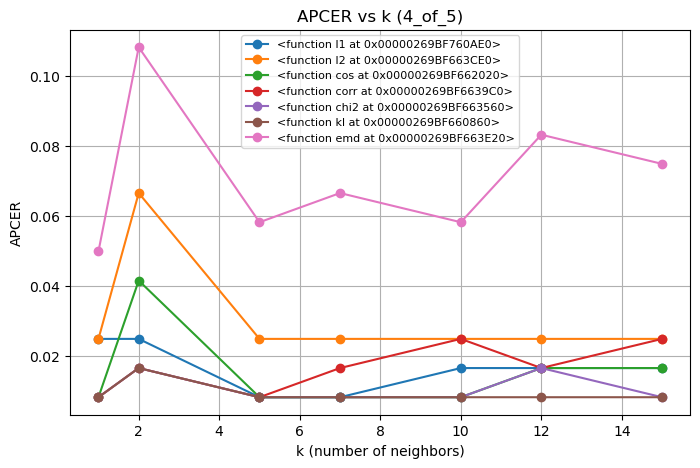

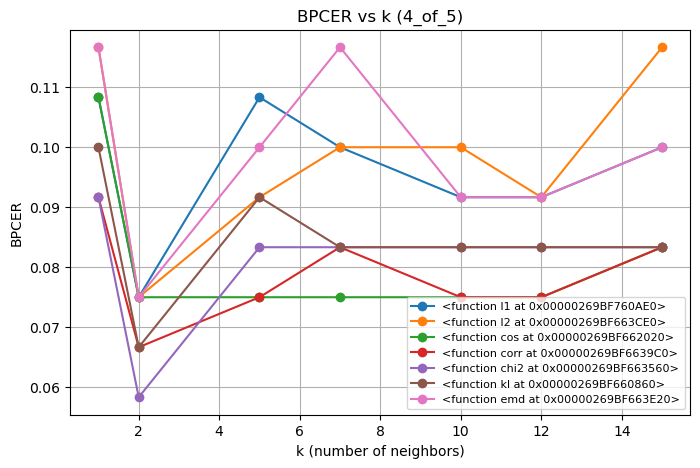

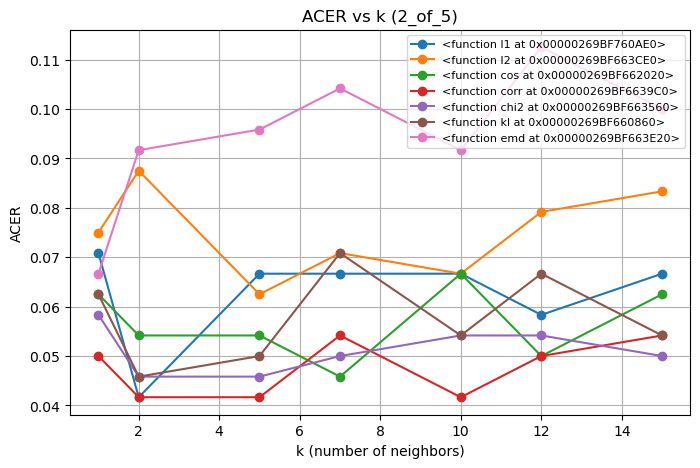

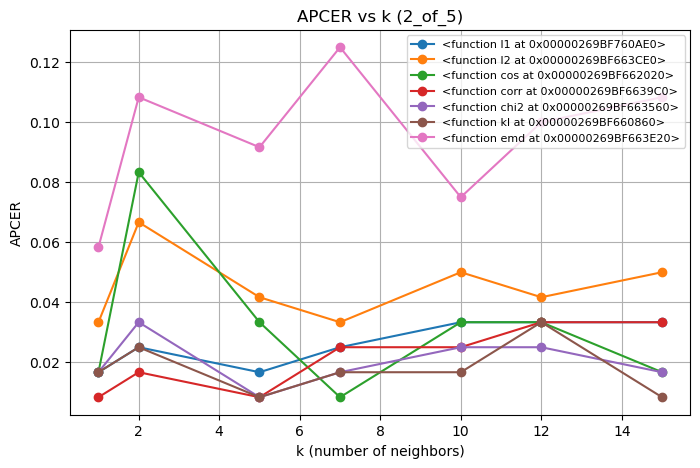

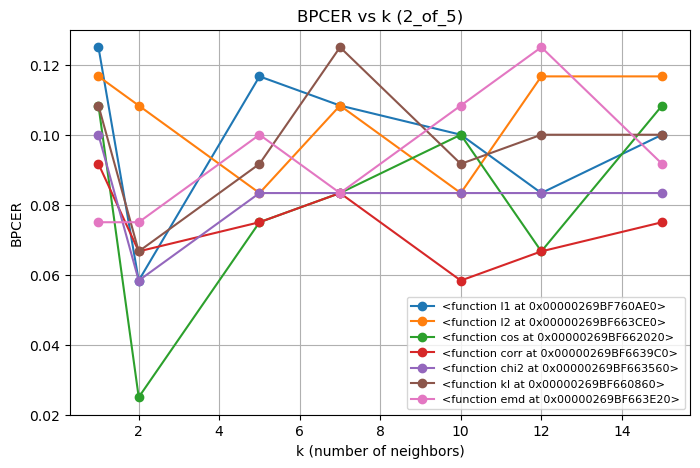

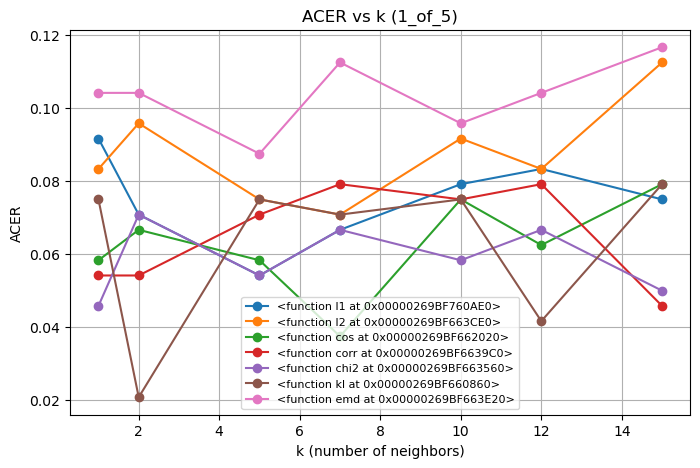

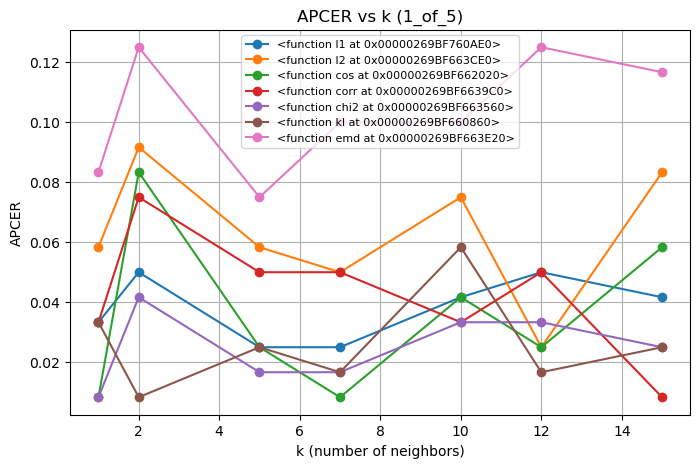

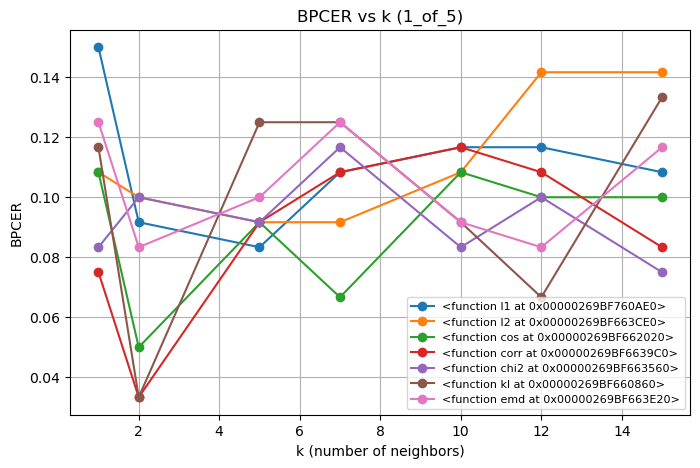

In [231]:
import matplotlib.pyplot as plt

Ks = [1, 2, 5, 7, 10, 12, 15]

rules = ['4_of_5', '2_of_5', '1_of_5']
metrics = ['ACER', 'APCER', 'BPCER']

for rule in rules:
    for metric in metrics:

        plt.figure(figsize=(8, 5))

        for dist_name, scores in results.items():
            y = [
                scores[k][rule][metric]
                for k in Ks
            ]
            plt.plot(Ks, y, marker='o', label=dist_name)

        plt.xlabel("k (number of neighbors)")
        plt.ylabel(metric)
        plt.title(f"{metric} vs k ({rule})")
        plt.legend(fontsize=8)
        plt.grid(True)

        plt.show()


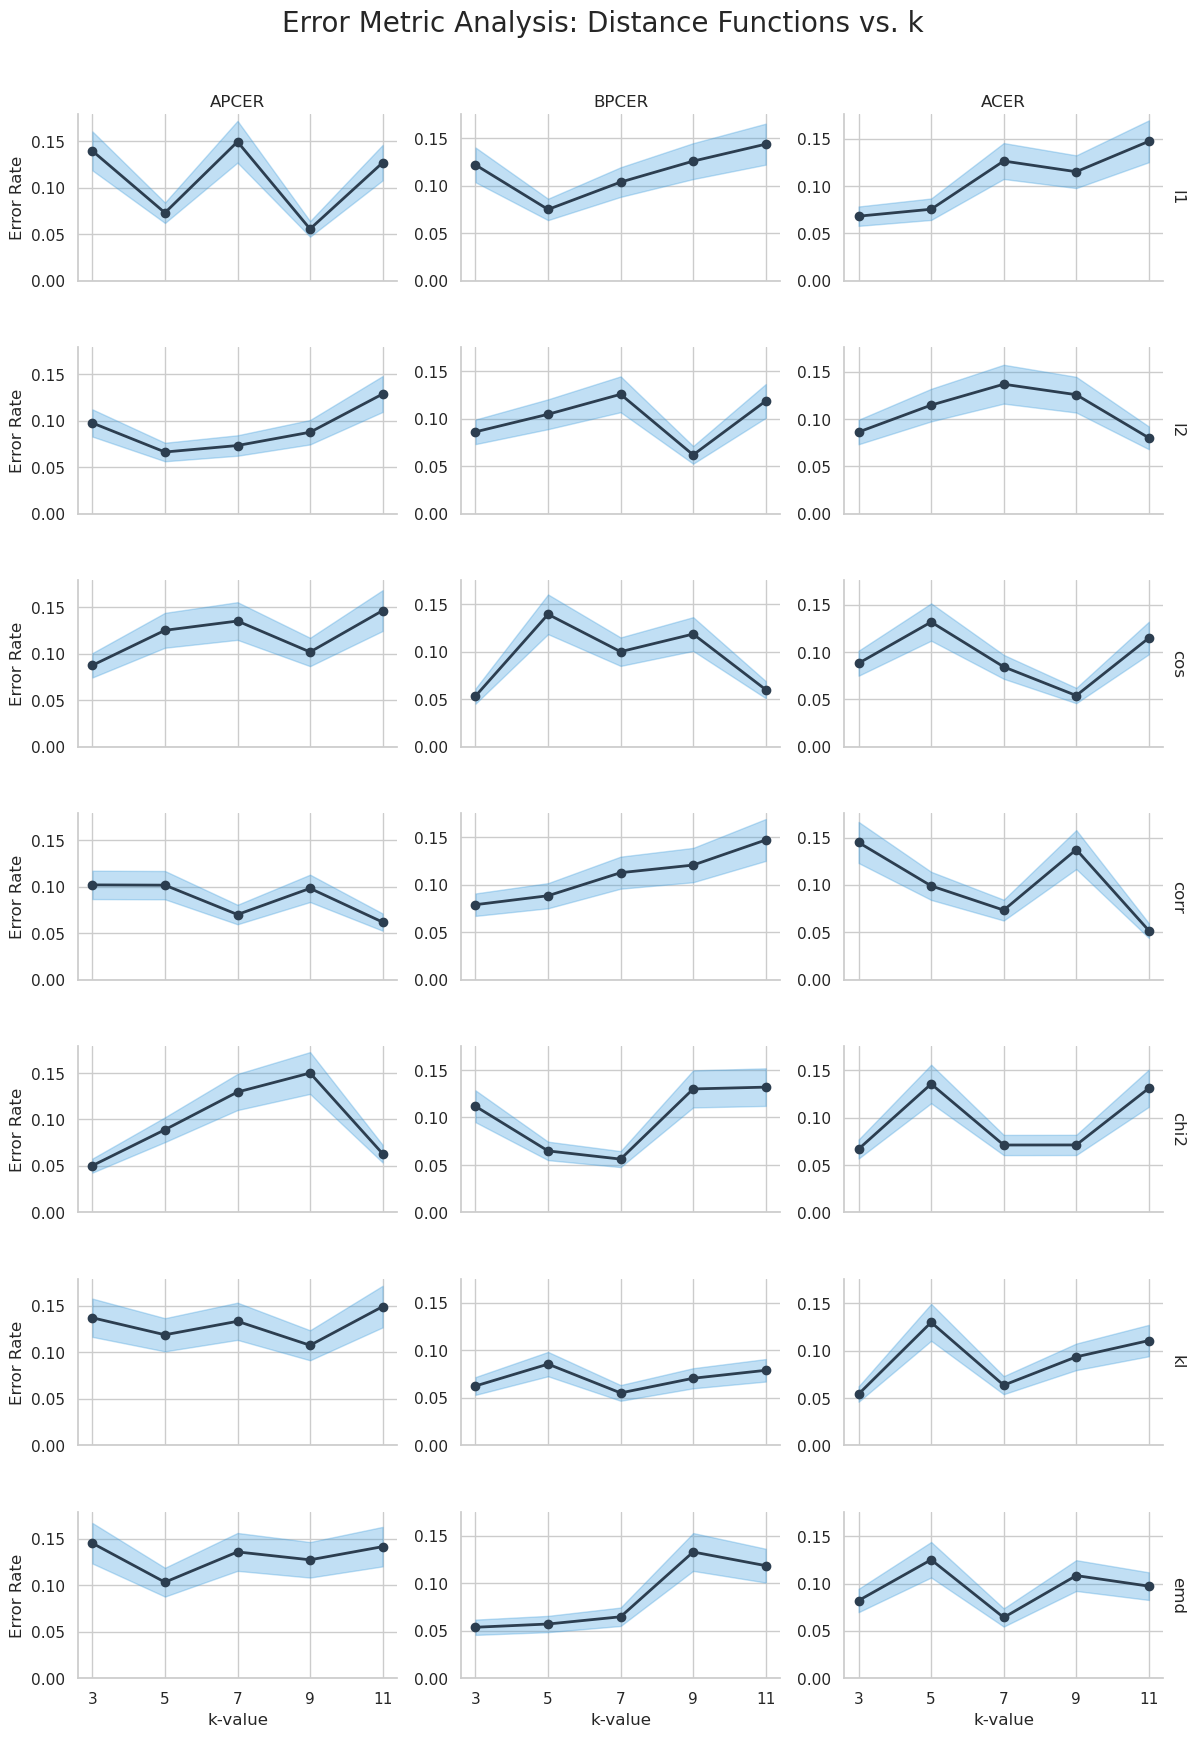

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1. Prepare Dummy Data (Replace this with your actual data)
ks = [3, 5, 7, 9, 11]
distances = ['l1', 'l2', 'cos', 'corr', 'chi2', 'kl', 'emd']
metrics = ['APCER', 'BPCER', 'ACER']

data_list = []
for m in metrics:
    for d in distances:
        for k in ks:
            # Synthetic mean and std for demonstration
            mean_val = np.random.uniform(0.05, 0.15) 
            std_val = mean_val * 0.15
            data_list.append({
                'k': k, 'Distance': d, 'Metric': m, 
                'Mean': mean_val, 'Std': std_val
            })

df = pd.DataFrame(data_list)

# 2. Setup the FacetGrid
# We set sharey='row' if metrics have different scales, 
# but usually for error rates, sharey='col' is better to compare distances.
sns.set_theme(style="whitegrid")
g = sns.FacetGrid(
    df, 
    row="Distance", 
    col="Metric", 
    height=2.5, 
    aspect=1.6, 
    margin_titles=True,
    sharey='col' # This allows comparing distances within the same metric column
)

# 3. Define the plotting function for the grid
def draw_error_curves(data, **kwargs):
    ax = plt.gca()
    data = data.sort_values('k')
    
    # Plot the mean line
    ax.plot(data['k'], data['Mean'], marker='o', linewidth=2, color='#2c3e50')
    
    # Plot the confidence interval (Mean +/- Std)
    ax.fill_between(
        data['k'], 
        data['Mean'] - data['Std'], 
        data['Mean'] + data['Std'], 
        alpha=0.3, 
        color='#3498db'
    )
    
    # Optional: Set integer ticks for k
    ax.set_xticks(ks)

# Apply the function to the grid
g.map_dataframe(draw_error_curves)

# 4. Final Polish
g.set_axis_labels("k-value", "Error Rate")
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.set(ylim=(0, None))

# Adjust layout to prevent title overlap
plt.subplots_adjust(top=0.92, hspace=0.4, wspace=0.2)
g.fig.suptitle('Error Metric Analysis: Distance Functions vs. k', fontsize=20)

plt.show()

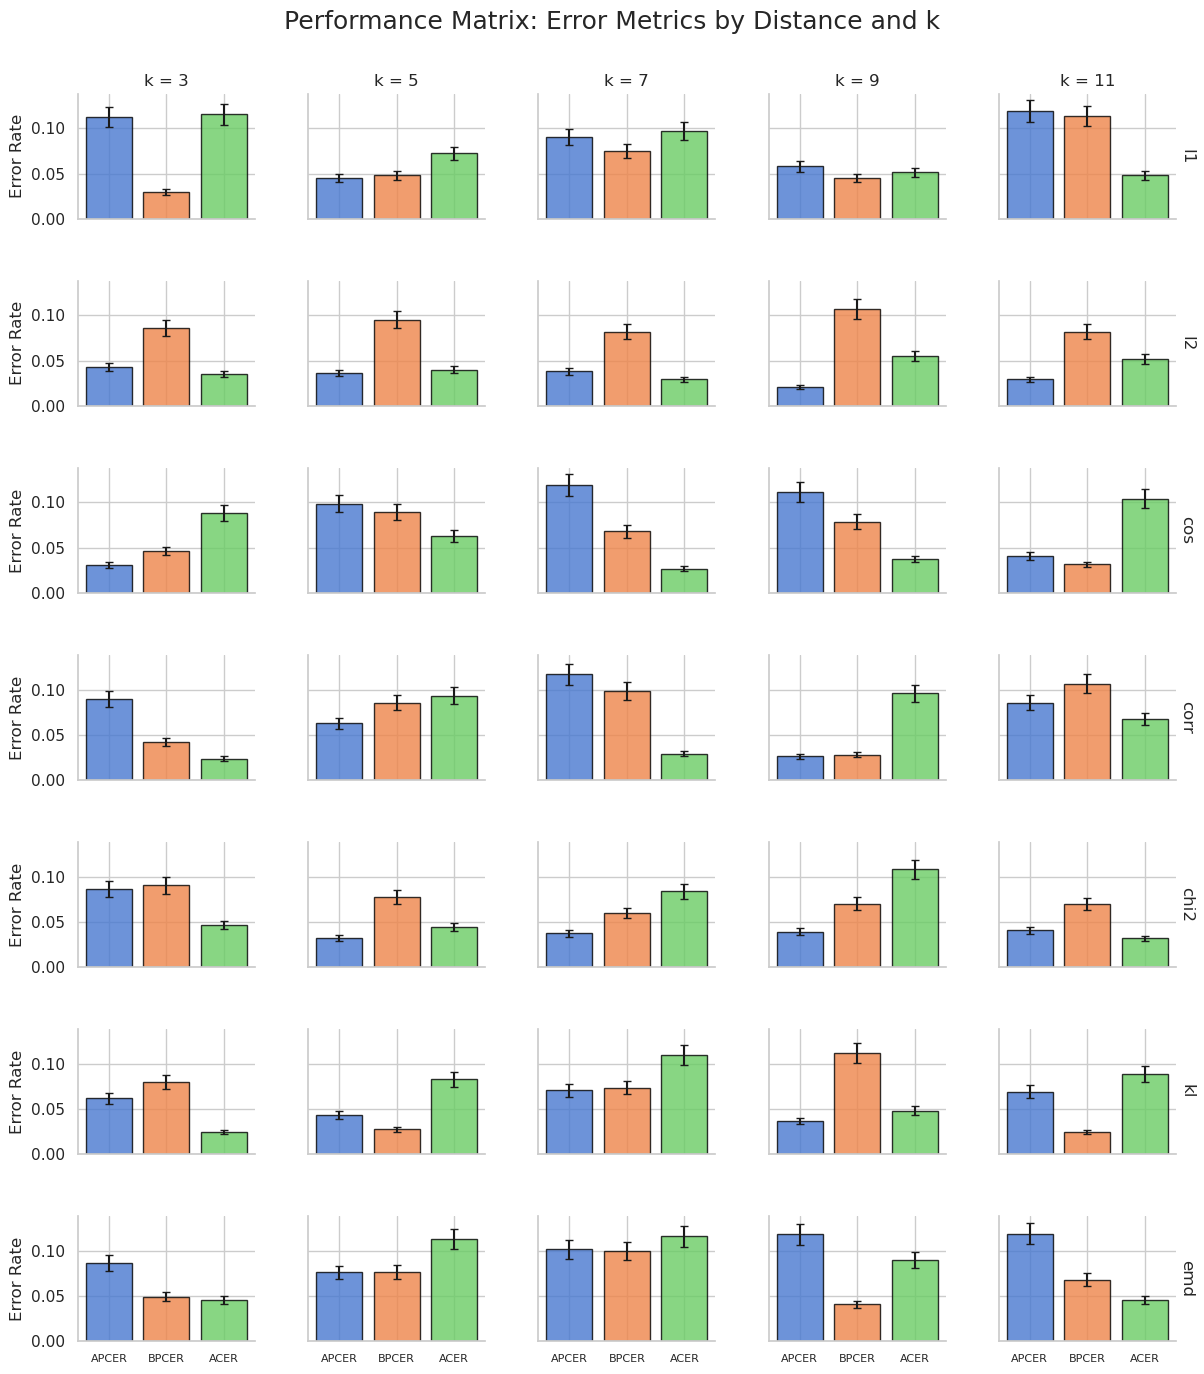

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1. Setup Data Structure (Replace with your actual data)
ks = [3, 5, 7, 9, 11]
distances = ['l1', 'l2', 'cos', 'corr', 'chi2', 'kl', 'emd']
metrics = ['APCER', 'BPCER', 'ACER']

data_list = []
for d in distances:
    for k in ks:
        for m in metrics:
            # Replace these with your actual Mean and Std values
            mean_val = np.random.uniform(0.02, 0.12)
            std_val = mean_val * 0.1 
            data_list.append({
                'Distance': d, 'k': k, 'Metric': m, 
                'Mean': mean_val, 'Std': std_val
            })

df = pd.DataFrame(data_list)

# 2. Setup Plotting Environment
sns.set_theme(style="whitegrid")

# Create the FacetGrid: rows=Distance, cols=k
g = sns.FacetGrid(
    df, 
    row="Distance", 
    col="k", 
    margin_titles=True, 
    height=2.0, 
    aspect=1.2, 
    sharey=True # Important for comparing magnitude across the grid
)

# 3. Define the custom bar plot function
def custom_barplot(data, **kwargs):
    ax = plt.gca()
    # Ensure order is always APCER, BPCER, ACER
    ordered_data = data.set_index('Metric').reindex(['APCER', 'BPCER', 'ACER']).reset_index()
    
    metrics_labels = ordered_data['Metric'].tolist()
    means = ordered_data['Mean'].tolist()
    stds = ordered_data['Std'].tolist()
    
    # Define colors for the 3 bars
    colors = sns.color_palette("muted", n_colors=3)
    
    # Plot bars with error bars
    ax.bar(metrics_labels, means, yerr=stds, color=colors, capsize=3, edgecolor='black', alpha=0.8)
    
    # Make X-labels small to fit
    ax.tick_params(axis='x', labelsize=8)

# Map the function
g.map_dataframe(custom_barplot)

# 4. Final Styling
g.set_axis_labels("", "Error Rate")
g.set_titles(row_template="{row_name}", col_template="k = {col_name}")

plt.subplots_adjust(top=0.92, hspace=0.5, wspace=0.3)
g.fig.suptitle('Performance Matrix: Error Metrics by Distance and k', fontsize=18)

plt.savefig('error_matrix_bars.png', dpi=300, bbox_inches='tight')
plt.show()